## import

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.semantic_segmentation.datasets.voc import (LABEL_COLORS,
                                                          VocSegmentation)
from torchlake.semantic_segmentation.models.parsenet import ParseNetFCN
from tqdm import tqdm

# setting

In [2]:
artifacts_path = Path("../../artifacts/parsenet")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 8
IMAGE_SIZE = 224
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
preprocess = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1), # in feature extractor
        ToTensorV2(),
    ]
)

test_preprocess = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1), # in feature extractor
        ToTensorV2(),
    ]
)

In [6]:
train_dataset = VocSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=preprocess,
)

test_dataset = VocSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_preprocess,
)

In [7]:
NUM_WORKERS = get_num_workers()

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

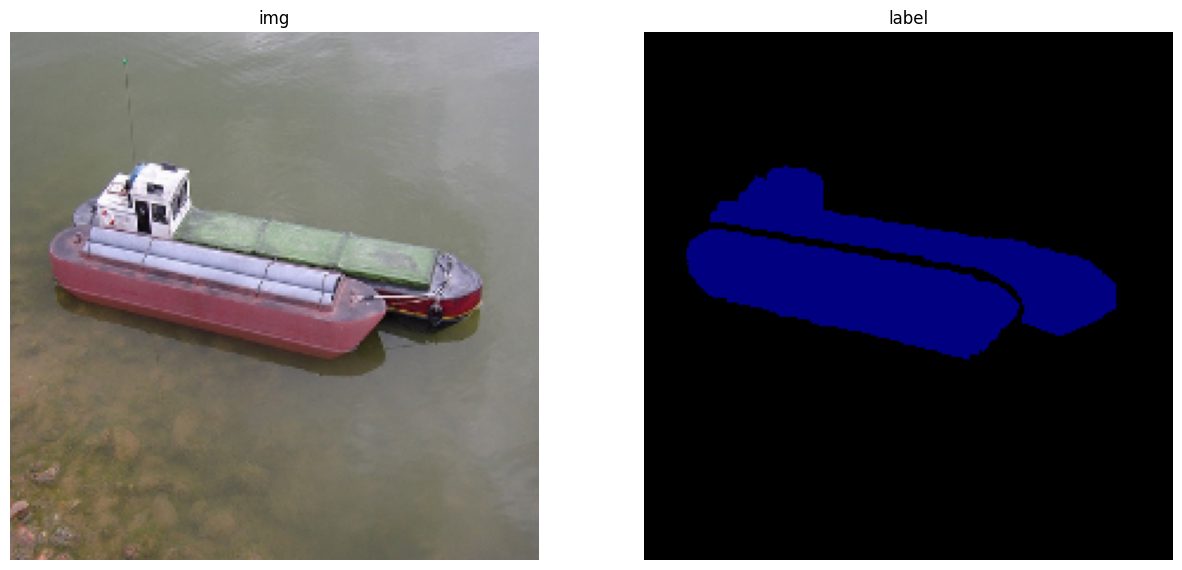

In [9]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

# train

In [10]:
EPOCHES = 5

In [11]:
trainer = ClassificationTrainer(EPOCHES, DEVICE)

In [12]:
criterion = trainer.get_criterion(NUM_CLASS)

In [13]:
prev_model = None
for num_skip_connection in range(0, 3):
    print(f"training FCN-{2**(5 - num_skip_connection)}s...")
    model = ParseNetFCN(NUM_CLASS + 1, num_skip_connection=num_skip_connection, frozen_backbone=True).to(DEVICE)
    
    if num_skip_connection > 0:
        print("updating weights...")
        model.backbone = prev_model.backbone
        model.conv = prev_model.conv
        for i in range(num_skip_connection - 1):
            model.pool_convs.pop(i)
            model.pool_convs.insert(i, prev_model.pool_convs.pop(0))
        for i in range(num_skip_connection - 2):
            model.upsamples.pop(i)
            model.upsamples.insert(i, prev_model.upsamples.pop(0))
        # print(model.pool_convs, model.upsamples)
        print("updated weights")
    
    optimizer = torch.optim.Adam(model.parameters(), lr=[1e-3, 1e-3, 1e-3][num_skip_connection])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')
    training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)
    # 8s check
    if num_skip_connection < 2:
        prev_model = model
        for param in prev_model.parameters():
            param.requires_grad_(False)

training FCN-32s...


100%|██████████| 364/364 [00:42<00:00,  8.50it/s]


epoch 1 : 0.11715988913080194


100%|██████████| 364/364 [00:41<00:00,  8.77it/s]


epoch 2 : 0.07286752054242643


100%|██████████| 364/364 [00:41<00:00,  8.78it/s]


epoch 3 : 0.05956996945091165


100%|██████████| 364/364 [00:41<00:00,  8.82it/s]


epoch 4 : 0.05194295926920169


100%|██████████| 364/364 [00:41<00:00,  8.78it/s]


epoch 5 : 0.04703190396693382
training FCN-16s...
updating weights...
updated weights


100%|██████████| 364/364 [00:40<00:00,  8.88it/s]


epoch 1 : 0.06059403282559508


100%|██████████| 364/364 [00:39<00:00,  9.12it/s]


epoch 2 : 0.03838112360060952


100%|██████████| 364/364 [00:40<00:00,  9.06it/s]


epoch 3 : 0.036171577154443815


100%|██████████| 364/364 [00:40<00:00,  9.03it/s]


epoch 4 : 0.03541125302909167


100%|██████████| 364/364 [00:40<00:00,  9.05it/s]


epoch 5 : 0.03456112358637236
training FCN-8s...
updating weights...
updated weights


100%|██████████| 364/364 [00:40<00:00,  9.10it/s]


epoch 1 : 0.0757447894058794


100%|██████████| 364/364 [00:39<00:00,  9.11it/s]


epoch 2 : 0.03824467234221379


100%|██████████| 364/364 [00:39<00:00,  9.13it/s]


epoch 3 : 0.036418291816876815


100%|██████████| 364/364 [00:40<00:00,  9.08it/s]


epoch 4 : 0.03596595067090795


100%|██████████| 364/364 [00:40<00:00,  9.10it/s]

epoch 5 : 0.03546816218838832


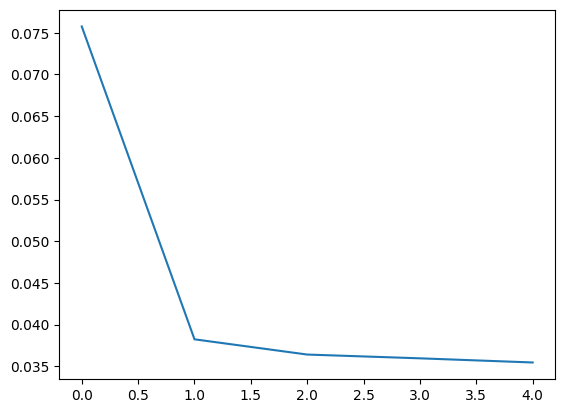

In [14]:
plt.plot(training_loss)

In [15]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
ParseNetFCN                                        --
├─VGGFeatureExtractor: 1-1                         --
│    └─Sequential: 2-1                             --
│    │    └─Conv2d: 3-1                            (1,792)
│    │    └─ReLU: 3-2                              --
│    │    └─Conv2d: 3-3                            (36,928)
│    │    └─ReLU: 3-4                              --
│    │    └─MaxPool2d: 3-5                         --
│    │    └─Conv2d: 3-6                            (73,856)
│    │    └─ReLU: 3-7                              --
│    │    └─Conv2d: 3-8                            (147,584)
│    │    └─ReLU: 3-9                              --
│    │    └─MaxPool2d: 3-10                        --
│    │    └─Conv2d: 3-11                           (295,168)
│    │    └─ReLU: 3-12                             --
│    │    └─Conv2d: 3-13                           (590,080)
│    │    └─ReLU: 3-14                 

In [22]:
model_path = artifacts_path.joinpath('parsent.fcn.8s.pth')

In [17]:
torch.save(model.state_dict(), model_path)

In [18]:
get_file_size(model_path)

'78.83MiB'

# inference

In [30]:
# if you did not train, but have pretrained one
model = ParseNetFCN(NUM_CLASS + 1, num_skip_connection=2, frozen_backbone=True).to(DEVICE)

In [31]:
model.load_state_dict(torch.load(model_path), strict=False)

<All keys matched successfully>

### dice coef

In [32]:
from torchmetrics.classification import jaccard

In [33]:
metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(DEVICE)

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        labels = labels.long()
        metric.update(output, labels)

100%|██████████| 79/79 [00:08<00:00,  8.82it/s]


In [34]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.69 
bicycle        : 0.24 
bird           : 0.76 
boat           : 0.63 
bottle         : 0.63 
bus            : 0.8  
car            : 0.72 
cat            : 0.81 
chair          : 0.05 
cow            : 0.6  
diningtable    : 0.71 
dog            : 0.67 
horse          : 0.52 
motorbike      : 0.48 
person         : 0.68 
pottedplant    : 0.29 
sheep          : 0.69 
sofa           : 0.44 
train          : 0.79 
tvmonitor      : 0.62 
----------------------
total          : 0.59 


### for image in dataset

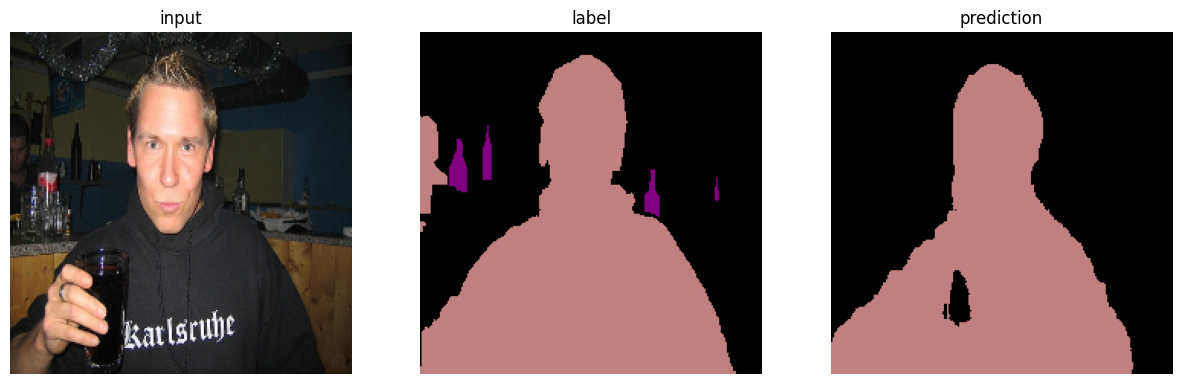

In [35]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

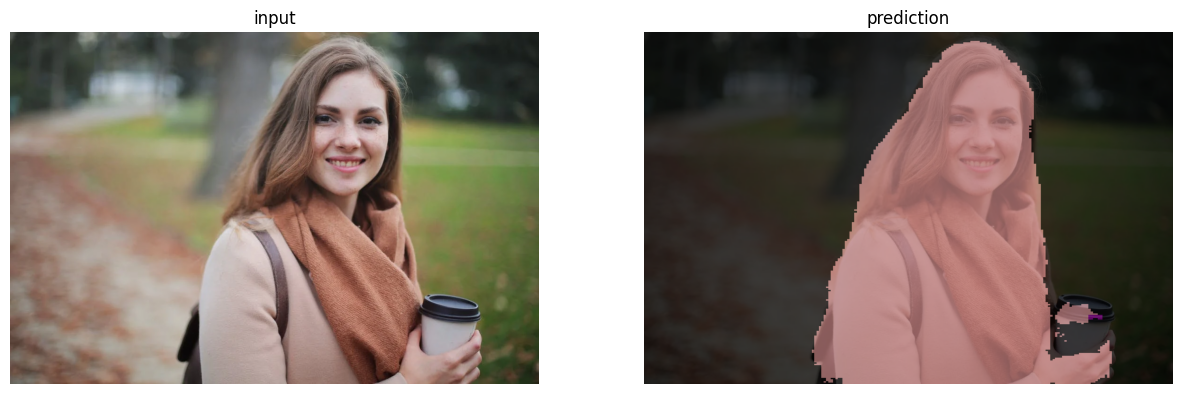

In [36]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_preprocess(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )